In [32]:
import numpy as np
import scipy 
import nimfa

from wav import load_wav, wavPlayer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
%matplotlib inline

# Matrix generation

Read any wav file and turn it into spectrogram matrix to test different methods on it.

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


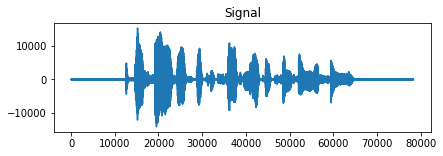

In [33]:
fs, s_clean = load_wav('../data/chime/clean/F01_22GC010A_BTH.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

In [34]:
f_clean, t_clean, Sxx_clean = scipy.signal.spectrogram(s_clean, fs=16000, nfft=1024)

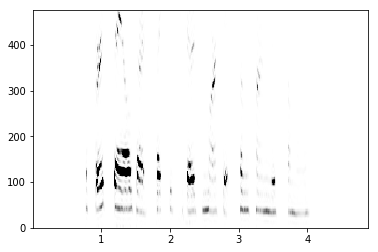

In [35]:
plt.pcolormesh(t_clean, f_clean[:150] / (len(s_clean) * 1. / fs), Sxx_clean[:150], cmap="Greys", vmax=40000)

In [36]:
V = Sxx_clean

# Multiplicative Updates methods

Minimization of Frobenius norm. For starting point let's use NNDSVD.

In [37]:
fctr_nmf_fro = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=200, update='euclidean',
                         objective='fro', track_error=True)

In [38]:
fctr_nmf_fro.factorize()
W_fro = fctr_nmf_fro.basis()
H_fro = fctr_nmf_fro.coef()

In [39]:
print ("fro: ", fctr_nmf_fro.fro())
print ("div: ", fctr_nmf_fro.div())

fro:  35386016122.47278
div:  9160438.201545844


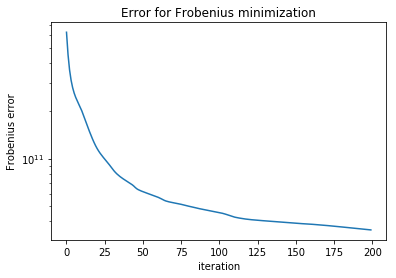

In [40]:
plt.title('Error for Frobenius minimization')
plt.semilogy(fctr_nmf_fro.tracker.get_error())
plt.xlabel('iteration')
plt.ylabel('Frobenius error')

Optimization of Kullback-Leibler divergence.

In [41]:
fctr_nmf_div = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=200, update='divergence',
                         objective='div', track_error=True)

In [42]:
fctr_nmf_div.factorize()
W_div = fctr_nmf_div.basis()
H_div = fctr_nmf_div.coef()

In [43]:
print ("fro: ", fctr_nmf_div.fro())
print ("div: ", fctr_nmf_div.div())

fro:  52747416794.9166
div:  2714872.5919939713


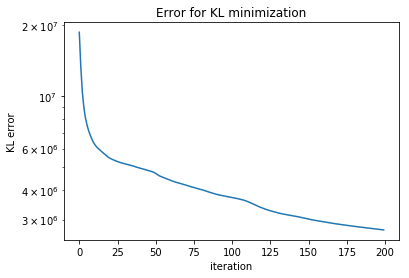

In [44]:
plt.title('Error for KL minimization')
plt.semilogy(fctr_nmf_div.tracker.get_error())
plt.xlabel('iteration')
plt.ylabel('KL error')

# ANLS

In [45]:
from nmf import ANLS

errors = []
def callback_err(A, W, H):
    
    errors.append(np.linalg.norm(A-W.dot(H))**2)

W, H = ANLS(V, rank=40, callback=callback_err, max_iter=200, seed='nndsvd')

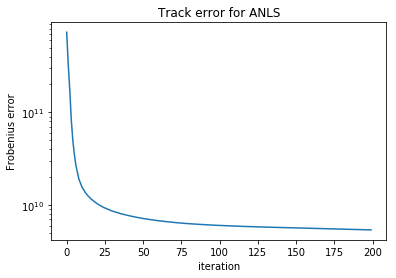

In [46]:
plt.title('Track error for ANLS')
plt.semilogy(errors)
plt.xlabel('iteration')
plt.ylabel('Frobenius error')

Looks nice!

# Comparison

In [47]:
from nimfa.utils.linalg import elop, sop, multiply, dot, div

def KL_distance(A, W, H):
    
    return np.sum(multiply(A,sop(elop(A, dot(W, H), div), op=np.log)) - A + dot(W, H))

In [48]:
error_l1_div = []
def callback_l1_div(V, W, H):
    error_l1_div.append(KL_distance(V, W, H))
model_div = NMF(n_components=40, init='nndsvd', solver='cd', max_iter=200, l1_ratio=1, alpha=1000)
model_div.fit(V, callback_l1_div)

NMF(alpha=1000, beta=1, eta=0.1, init='nndsvd', l1_ratio=1, max_iter=200,
  n_components=40, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [49]:
m_it = 200
fctr_nmf_fro = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=m_it, update='euclidean',
                         objective='fro', track_error=True)
fctr_nmf_div = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=m_it, update='divergence',
                         objective='div', track_error=True)

In [50]:
errors_als = []
errors_als_kl = []
def callback_err(A, W, H):
    
    errors_als.append(np.linalg.norm(A-W.dot(H))**2)
    errors_als_kl.append(KL_distance(A, W, H))

W_als, H_als = ANLS(V, rank=40, callback=callback_err, max_iter=m_it, seed='nndsvd')

fctr_nmf_fro.factorize()
W_fro = fctr_nmf_fro.basis()
H_fro = fctr_nmf_fro.coef()

errors_fro = fctr_nmf_fro.tracker.get_error()


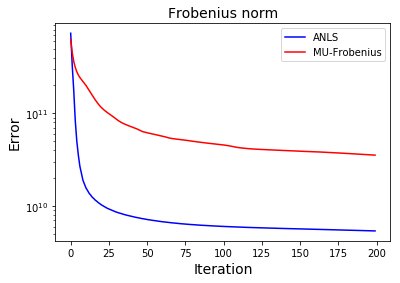

In [51]:
plt.title('Frobenius norm', fontsize=14)
plt.semilogy(errors_als, c='blue', label='ANLS')
plt.semilogy(errors_fro, c='red', label='MU-Frobenius')
plt.ylabel('Error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(loc='best')
plt.savefig("../presentation/frobenius.png", bbox_inches="tight")

**sklearn** implementation works similar to our ANLS. Considering fact that authors of **sklearn** used ALS too and solved subproblem with Coordinate descent which is close to our approuch the result is not strange.

In [52]:
fctr_nmf_div.factorize()
W_div = fctr_nmf_div.basis()
H_div = fctr_nmf_div.coef()

#errors_fro = fctr_nmf_fro.tracker.get_error()
errors_div = fctr_nmf_div.tracker.get_error()

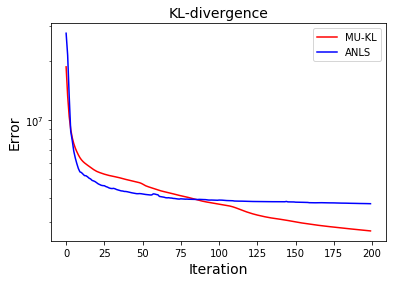

In [53]:
plt.title('KL-divergence', fontsize=14)
plt.semilogy(errors_div, c='red', label='MU-KL')
plt.plot(errors_als_kl, c='blue', label='ANLS')
plt.ylabel('Error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(loc='best')
plt.savefig("../presentation/KLdiv.png", bbox_inches="tight")

For KL divergence our implementation is better.

So, we implemented ANLS, method with L1-regularization, Quasi-Newton method and tried to use MU from **nimfa** and ANLS with regularization from **sklearn**. As for Quasi-Newton, implementation may be found in **nmf.py**, but it needs a lot of memory and we can't use it for our matrices, also it contains inversion of hessian. We have found Levenberg-Marquardt modification of this method, which should help with hessian inversion, but we didn't have time to do it. So, it is better to use any gradient method with multistart instead of Quasi-Newton, moreover problem is multiextremal.